# Social Ads

In [1]:
#! git clone https://github.com/cesar-claros/synergistic
#% cd synergistic/

## Dependencies 

In [ ]:
#%%
# Command line instalation
# ---------------------------
#! pip install torch
#! pip install gpytorch

# Imports
# ---------------------------
import io #Used as buffer
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.funcs as sgn
import seaborn as sns
import torch
import tensorflow as tf
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, decomposition,\
     tree, neighbors, discriminant_analysis, gaussian_process, preprocessing
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
import os
import random

## Auxiliar functions 

In [3]:
#%%
# MODELS
# ====================
# Grid search for parameters and classifiers

models = { 
        'predictor':
            [
            svm.SVC(),
            gaussian_process.GaussianProcessClassifier(),
            linear_model.LinearRegression(),
            linear_model.Lasso(),
            svm.SVR()],
        'name':
            [
            'SVM',
            'GPClassifier',
            'LinReg',
            'Lasso',
            'SVR']}
parameters = [
            {'SVM__kernel':['poly'],'SVM__degree':[3,4,5]},
            {'GPClassifier__kernel':[]},
            {},
            {'Lasso__alpha':np.linspace(0.01,1,10)},
            {'SVR__kernel':['linear'], 'SVR__C':np.logspace(-1, 1, 10), 'SVR__epsilon':np.logspace(-2, 2, 10)} ]

In [4]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01'):
    # X_train, X_val should be scaled
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False), rho_grid=[0.1, 0.15])
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [5]:
#%%
# Initialize model
def init_model(input_dim, models, parameters, clf):
    
    if clf=='svm':
      i = 0
    elif clf=='gpc':
      i = 1
      kernel = 1.0 * RBF(length_scale=1.0*np.ones(input_dim)) 
      parameters[i]['GPClassifier__kernel'].append(kernel)
      
    scaler = preprocessing.StandardScaler()
    steps = [('scaler', scaler), (models['name'][i], models['predictor'][i])]
    ppline = pipeline.Pipeline(steps) # define the pipeline object.

    clf = model_selection.GridSearchCV(ppline, param_grid=parameters[i], cv=5)
    return clf

In [6]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X):
    if hasattr(model, "decision_function"):
      y_pred_soft = model.best_estimator_.decision_function(X)[:,None]
      y_pred_th = model.best_estimator_.predict(X)
    else:
      y_pred_soft = model.best_estimator_.predict_proba(X)
      y_pred_th = model.best_estimator_.predict(X)
    return y_pred_soft, y_pred_th

In [7]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [8]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf,trust_val,trust_test):
      if clf=='svm':
          direction = 'closer'
          crit_val  = np.abs(y_val_pred_soft.ravel())
          crit_test = np.abs(y_test_pred_soft.ravel())
      else:
          direction = 'further'
          p_val = np.concatenate((y_val_pred_soft,1-y_val_pred_soft),axis=1)
          crit_val  = entropy(p_val, axis=1, base=2)
          p_test    = np.concatenate((y_test_pred_soft,1-y_test_pred_soft),axis=1)
          crit_test = entropy(p_test, axis=1, base=2)
      # Criteria 1
      critFunc   = sgn.critEvaluation(norm='l01',direction=direction)
      d_val      = critFunc.evaluate(y_val, y_val_pred_th, crit_val, rho_grid=[0.1, 0.15])
      d_test     = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)   
      # Best rules from signailing function on val are used to get UCBs on test
      gamma      = table['rule'].to_numpy().reshape(-1,1)
      f_test     = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      # Threshold values on val data. UCB Signailing (eta) and new criteria (theta) 
      eta        = table['eta'].to_numpy().reshape(-1,1)
      theta      = crit_table['thresh'].to_numpy().reshape(-1,1)        
      if direction == 'closer':
        crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)<theta)
      else:
        crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)>theta)
      f_mask, f_idx = np.nonzero(f_test>eta)
      shared = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask))))
      # Jaccard index btw signaled instances using both methods for ith rule-threshold
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan for i in range(f_test.shape[0])]            
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in range(f_test.shape[0])]
      crit_table['spearman'] = Sp
      crit_table['gamma'] = gamma
        
      # Criteria 2
      critFuncSc = sgn.critEvaluation(norm='l01',direction='closer')
      s_val      = critFuncSc.evaluate(y_val, y_val_pred_th, trust_val, rho_grid=[0.1, 0.15])
      s_test     = critFuncSc.test(y_test, y_test_pred_th, trust_test, s_val['thresh'].to_numpy())
      score_table= pd.concat([s_val,s_test],axis=1)
      # Threshold values on val data. TrustScore (theta0) 
      theta0     = score_table['thresh'].to_numpy().reshape(-1,1) 
      crit_mask0, crit_idx0 = np.nonzero(trust_test.reshape(1,-1)<theta0)
      # Jaccard index btw signaled instances using both methods for ith rule-threshold  
      shared0    = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask0))))
      J0         = [jaccard_similarity(crit_idx0[crit_mask0==i],f_idx[f_mask==i]) if i in shared0 else np.nan for i in range(f_test.shape[0])]
      Sp0        = [spearmanr(f_test[i,:],trust_test)[0] for i in range(f_test.shape[0])]
      score_table['jaccard']  = J0 
      score_table['spearman'] = Sp0      
      return crit_table,score_table,crit_test

## Signailing function & baselines

In [9]:
#%%
# Load data
# ---------------------------
df = pd.read_table('datasets/Social_Network_Ads.csv')
Data_X = df.iloc[:,[2,3]]
Data_y = df.iloc[:,4]
Data_X = Data_X.to_numpy()
Data_y = Data_y.to_numpy()

# Seed definition for reproducibility
# ---------------------------
os.environ['TF_DETERMINISTIC_OPS'] = '1'
SEED = 123456
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
#%%
# Cross validation setup
# ---------------------------
report_table    = []
report_criteria = []
trust_criteria  = []
addPredictions  = False
clf      = 'svm' #'gpc'
accuracy = 0
fold     = 1
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# ML model fit + Signailing function + Baseline comparison
# ---------------------------
for sample, test in kf.split(Data_X, Data_y):
    X = Data_X[sample]
    y = Data_y[sample]
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.20, random_state=SEED)
    X_test = Data_X[test]
    y_test = Data_y[test]

    # ML Model fit & prediction
    model = init_model(input_dim=X.shape[1], models=models, parameters=parameters, clf=clf)
    model.fit(X_train, y_train)
    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train)
    y_val_pred_soft  , y_val_pred_th   = pred_output(model, X_val)
    y_test_pred_soft , y_test_pred_th  = pred_output(model, X_test)
    print('accuracy(Train)={}'.format(np.sum(y_train==y_train_pred_th)/np.size(y_train)))
    
    if addPredictions:
        X_train_GP = np.concatenate((X_train, y_train_pred_soft), axis=1)
        X_val_GP   = np.concatenate((X_val, y_val_pred_soft), axis=1)
        X_test_GP  = np.concatenate((X_test, y_test_pred_soft), axis=1)
        scaleX_GP  = preprocessing.StandardScaler().fit(X_train_GP)
        X_train_GP = scaleX_GP.transform(X_train_GP)
        X_val_GP   = scaleX_GP.transform(X_val_GP)
        X_test_GP  = scaleX_GP.transform(X_test_GP)

    scaleX_GP  = preprocessing.StandardScaler().fit(X_train)
    X_train_GP = scaleX_GP.transform(X_train)
    X_val_GP   = scaleX_GP.transform(X_val)
    X_test_GP  = scaleX_GP.transform(X_test)

    # Signailing function. Call
    table, exp = signalingFunction(X_train_GP, y_train, y_train_pred_th, X_val_GP, y_val, y_val_pred_th, X_test_GP, y_test, y_test_pred_th)

    report_table.append(pd.concat([pd.DataFrame({'fold':[fold]*table.shape[0]}),table],axis=1))

    # Trust Score fitted on train data to evaluate loss reduction on val-test data
    trust_model = sgn.trust_score()
    trust_model.fit(X=X_train_GP,y=y_train)
    trust_val  = trust_model.get_score(X_val_GP, y_val_pred_th)
    trust_test = trust_model.get_score(X_test_GP, y_test_pred_th)
    
    # Baseline for comparison
    crit_table,score_table,crit_test = baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf, trust_val, trust_test)
    report_criteria.append(pd.concat([pd.DataFrame({'fold':[fold]*crit_table.shape[0]}),crit_table],axis=1))
    trust_criteria.append(pd.concat([pd.DataFrame({'fold':[fold]*score_table.shape[0]}),score_table],axis=1))

    if accuracy < model.best_estimator_.score(X_val,y_val):
        accuracy             = model.best_estimator_.score(X_val,y_val)
        classifier           = model.best_estimator_
        model_predict        = model
        X_test_surface_plot  = X_test
        y_test_surface_plot  = y_test
        X_train_surface_plot = X_train
        y_train_surface_plot = y_train
        X_val_surface_plot   = X_val
        y_val_surface_plot   = y_val
        scaler_surface_plot  = scaleX_GP
        exp_surface_plot     = exp
        table_surface_plot   = table
        trust_surface_plot   = trust_test
        crit_surface_plot    = crit_test
    fold +=1
    del(model)

## Output visualization 

In [11]:
#%%
# Command line instalation
# ---------------------------
#! sudo apt-get install texlive-latex-recommended #1
#! sudo apt-get install dvipng texlive-fonts-recommended #2
#! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
#! unzip type1cm.zip -d /tmp/type1cm #4
#! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
#! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
#! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
#! sudo texhash #8

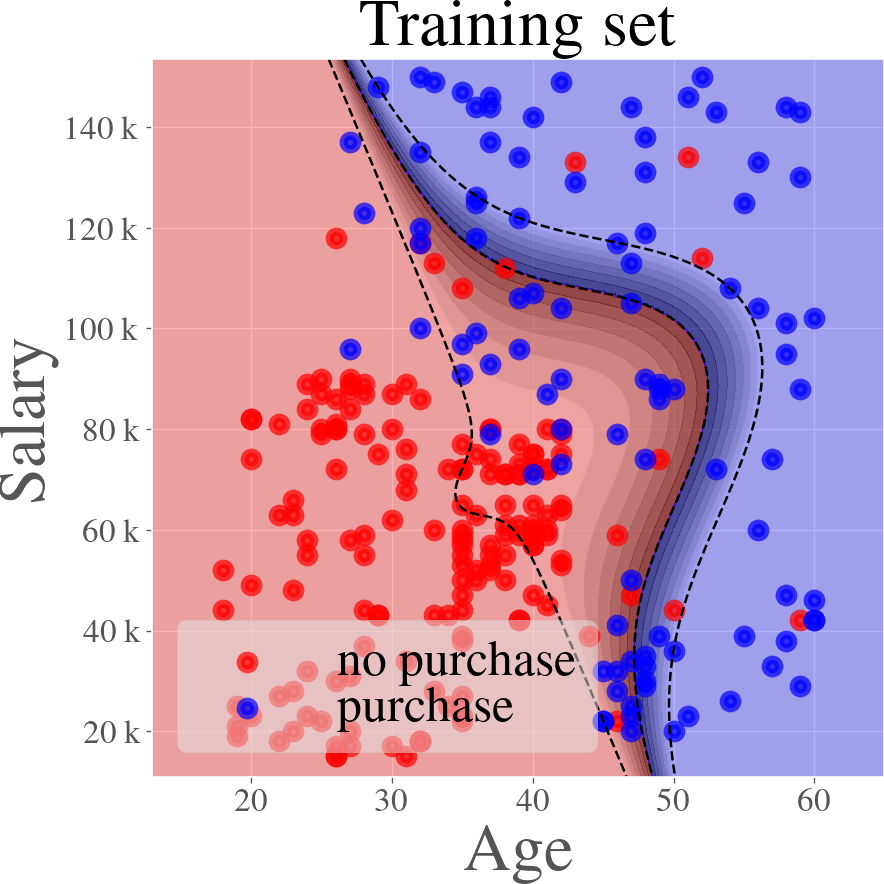

In [12]:
#%%
# PLOT DECISION SURFACE
# ==================
# Plot test instances and decision surface
# ----------------------------------------------
# Visualising the Train set results
plt.style.use(['ggplot','style/style.mplstyle'])
fig1 = plt.figure(figsize=(8,8),dpi=120)
ax1  = fig1.add_subplot(111)
X_set, y_set = X_train_surface_plot, y_train_surface_plot
y_set[y_set==0] = -1
if hasattr(classifier, "decision_function"):
    d_set = 1-y_set*classifier.decision_function(X_set)
else:
    pred_x = classifier.predict(X_set)
    pred_x[pred_x==0] = -1
    d_set = y_set*pred_x
xi_set = np.max([[np.zeros(d_set.size)],[d_set]],axis=0).ravel()

aranged_ages = np.arange(start = X_set[:, 0].min()-5, stop = X_set[:, 0].max()+5, step = 0.025)
aranged_salaries = np.arange(start = X_set[:, 1].min()-4000, stop = X_set[:, 1].max()+4000, step = 500)

X1, X2 = np.meshgrid(aranged_ages, aranged_salaries)
Z = classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
if hasattr(classifier, "decision_function"):
    d = classifier.decision_function(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    ax1.contourf(X1, X2, np.where((np.abs(d)<1),np.abs(d),np.nan), alpha = 0.6, cmap='gist_gray')# label='margin region'
    ax1.contour(X1, X2, d, levels=[-1, 0, 1], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set>1,0]
    y = X_set[xi_set>1,1]
else:
    d = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T)[:, 1].reshape(X1.shape)-0.5
    ax1.contourf(X1, X2, np.where((np.abs(d)<0.25),np.abs(d),np.nan), alpha = 0.6, cmap='gist_gray') #label='margin region'
    ax1.contour(X1, X2, d, levels=[-0.25, 0.0, 0.25], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set==0,0]
    y = X_set[xi_set==0,1]
dots = ['red','blue']
for i, j in enumerate(np.unique(y_set)):
    ax1.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color = dots[i], label = '{}'.format('no purchase' if i==0 else 'purchase'),alpha=0.7, s=65, linewidths=5)
# Plot slack variables magnitudes
#ax1.scatter(x, y, s=150, facecolors='none', edgecolors='g', linewidths=5) # label='misclassified'

ax1.set_xlabel('Age', fontsize=40)
ax1.set_ylabel('Salary', fontsize=40)
ax1.set_title('Training set', fontsize=40)
ax1.legend(loc='lower left', framealpha=0.5, prop={'size': 30}, labelspacing=0.0)
formatter0 = matplotlib.ticker.EngFormatter()
ax1.yaxis.set_major_formatter(formatter0)
X1_min, X1_max = X1.min(), X1.max()
X2_min, X2_max = X2.min(), X2.max()
ax1.set_xlim(X1_min, X1_max)
ax1.set_ylim(X2_min, X2_max)
plt.tight_layout()

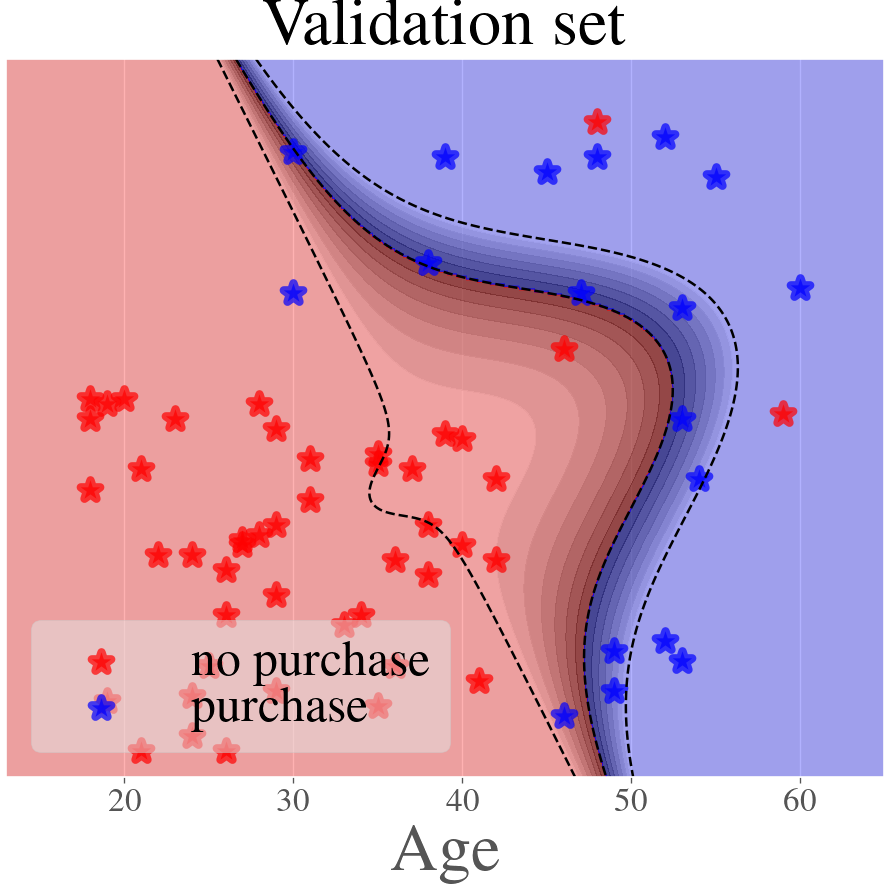

In [13]:
#%%
# PLOT DECISION SURFACE
# ==================
# Plot test instances and decision surface
# ----------------------------------------------
# Visualising the Train set results
fig1 = plt.figure(figsize=(8,8),dpi=120)
ax1 = fig1.add_subplot(111)
X_set, y_set = X_val_surface_plot, y_val_surface_plot
y_set[y_set==0] = -1
if hasattr(classifier, "decision_function"):
    d_set = 1-y_set*classifier.decision_function(X_set)
else:
    pred_x = classifier.predict(X_set)
    pred_x[pred_x==0] = -1
    d_set = y_set*pred_x
xi_set = np.max([[np.zeros(d_set.size)],[d_set]],axis=0).ravel()
if hasattr(classifier, "decision_function"):
    d = classifier.decision_function(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    ax1.contourf(X1, X2, np.where((np.abs(d)<1),np.abs(d),np.nan), alpha = 0.6, cmap='gist_gray') # label='margin region'
    ax1.contour(X1, X2, d, levels=[-1,0,1], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set>1,0]
    y = X_set[xi_set>1,1]
else:
    d = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T)[:, 1].reshape(X1.shape)-0.5
    ax1.contourf(X1, X2, np.where((np.abs(d)<0.25),np.abs(d),np.nan), alpha = 0.6, cmap='gist_gray') # label='margin region'
    ax1.contour(X1, X2, d, levels=[-0.25, 0, 0.25], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set==0,0]
    y = X_set[xi_set==0,1]

dots = ['red','blue']
for i, j in enumerate(np.unique(y_set)):
    ax1.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color = dots[i], label = '{}'.format('no purchase' if i==0 else 'purchase'),alpha=0.7,s=150, marker='*', linewidths=5)
# Plot slack variables magnitudes
#ax1.scatter(x, y, s=150, facecolors='none', edgecolors='g', linewidths=5) #label='misclassified'
 
ax1.set_xlabel('Age',fontsize=40)
ax1.set_yticks([])
ax1.set_title('Validation set',fontsize=40)
ax1.legend(loc='lower left', framealpha=0.5, prop={'size': 30},labelspacing=0.0)
ax1.set_xlim(X1_min, X1_max)
ax1.set_ylim(X2_min, X2_max)
plt.tight_layout()
#path_fig_fx_val = "drive/My Drive/NIPS2020/results/socialadsnet/fig_fx_val_{clf}_yhat{yhat}_pca{pca}.svg".format(clf=clf, pca=applyPCA, yhat=addPredictions)
#plt.savefig(path_fig_fx_val, bbox_inches='tight', facecolor='w')

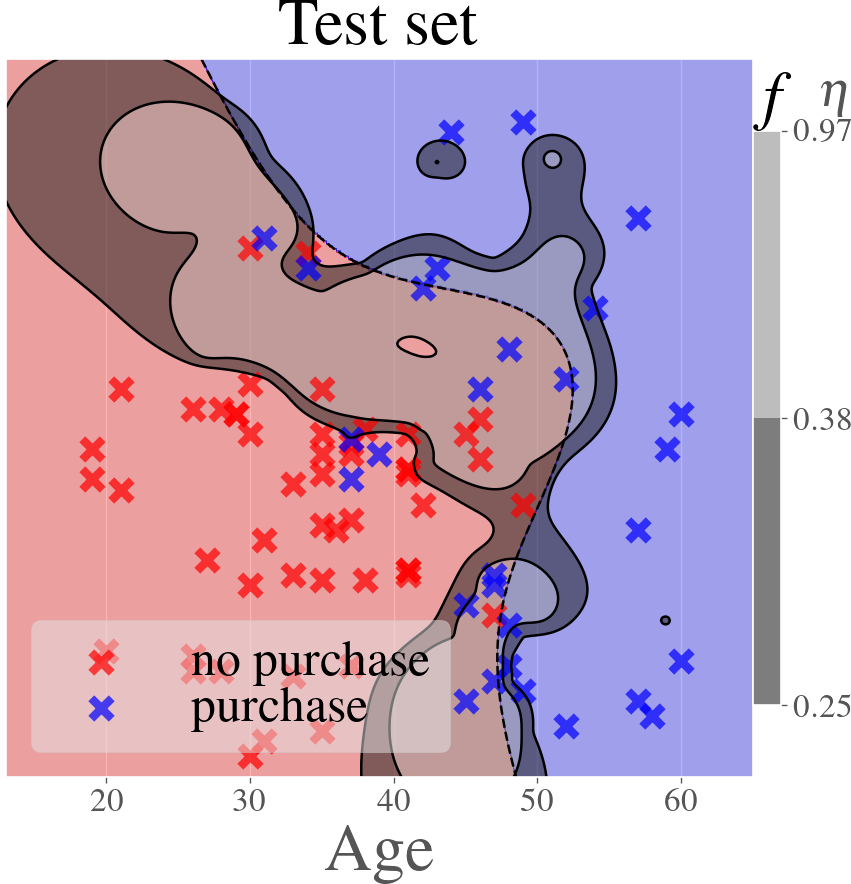

In [14]:
#%%
# Plot decision surface
# ---------------------------
t = np.stack((X1.ravel(), X2.ravel()), axis=1)

# Adding predictions to feature matrix if required
if addPredictions:
    y_test_pred_soft, y_test_pred_th = pred_output(model_predict, t)
    t0 = np.concatenate((t,y_test_pred_soft), axis=1)
else:
    t0 = t
# Scaling data for loss prediction
t_scaled = scaler_surface_plot.transform(t0)
f,v = exp_surface_plot.gpr.predict(t_scaled)
f   = f.reshape(X1.shape)

# Visualizing test results
# ---------------------------
fig1 = plt.figure(figsize=(8,8),dpi=120)
ax1  = fig1.add_subplot(111)
X_set, y_set = X_test_surface_plot, y_test_surface_plot
y_set[y_set==0] = -1
if hasattr(classifier, "decision_function"):
    d_set = 1-y_set*classifier.decision_function(X_set)
else:
    pred_x = classifier.predict(X_set)
    pred_x[pred_x==0] = -1
    d_set = y_set*pred_x
xi_set = np.max([[np.zeros(d_set.size)],[d_set]],axis=0).ravel()
if hasattr(classifier, "decision_function"):
    d = classifier.decision_function(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    ax1.contour(X1, X2, d, levels=[0], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set>1,0]
    y = X_set[xi_set>1,1]
else:
    d = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T)[:, 1].reshape(X1.shape)
    ax1.contour(X1, X2, d, levels=[0.5], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set==0,0]
    y = X_set[xi_set==0,1]

f_set = table_surface_plot['eta'].to_numpy()[::-1]
f_set = np.unique(np.around(np.append(f_set, f.max()), decimals=2))
cs = ax1.contourf(X1, X2, f, f_set, origin='upper', cmap='gray', alpha=0.5)
ax1.contour(X1, X2, f, f_set, colors='black')
cbar = fig1.colorbar(cs, pad=0.0, shrink=0.80)
cbar.ax.set_title(r'$f$', fontsize=40, loc='left')
cbar.set_label(r'$\eta$', labelpad=-10, y=1.10, rotation=0, fontsize=30)
dots = ['red','blue']
for i, j in enumerate(np.unique(y_set)):
    ax1.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color = dots[i], label = '{}'.format('no purchase' if i==0 else 'purchase'), alpha=0.7, s=150,marker='x', linewidth=5)
# Plot slack variables magnitudes
#ax1.scatter(x, y, s=150, facecolors='none', edgecolors='g', label='misclassified', linewidths=5)

ax1.set_xlabel('Age',fontsize=40)
ax1.set_yticks([])
ax1.set_title('Test set',fontsize=40)
ax1.legend(loc='lower left', framealpha=0.5, prop={'size': 30}, labelspacing=0.0)
ax1.set_xlim(X1_min, X1_max)
ax1.set_ylim(X2_min, X2_max)
plt.tight_layout()
#path_fig_fx_test = "drive/My Drive/NIPS2020/results/socialadsnet/fig_fx_test_{clf}_yhat{yhat}_pca{pca}.svg".format(clf=clf, pca=applyPCA, yhat=addPredictions)
#plt.savefig(path_fig_fx_test, bbox_inches='tight', facecolor='w')

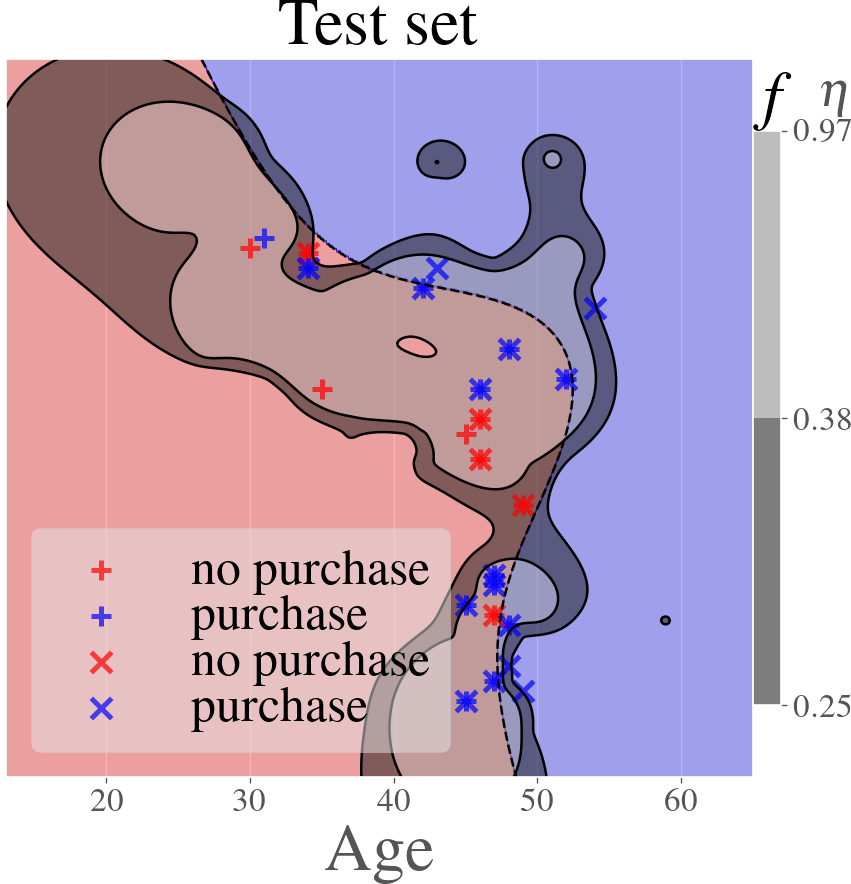

In [15]:
#%%
# Plot decision surface
# ---------------------------
t = np.stack((X1.ravel(), X2.ravel()), axis=1)

trust_q1 = trust_surface_plot < np.quantile(trust_surface_plot,0.25)
crit_q1  = crit_surface_plot < np.quantile(crit_surface_plot,0.25)

# Adding predictions to feature matrix if required
if addPredictions:
    y_test_pred_soft, y_test_pred_th = pred_output(model_predict, t)
    t0 = np.concatenate((t,y_test_pred_soft), axis=1)
else:
    t0 = t
# Scaling data for loss prediction
t_scaled = scaler_surface_plot.transform(t0)
f,v = exp_surface_plot.gpr.predict(t_scaled)
f   = f.reshape(X1.shape)

# Visualizing test results
# ---------------------------
fig1 = plt.figure(figsize=(8,8),dpi=120)
ax1  = fig1.add_subplot(111)
X_set, y_set = X_test_surface_plot, y_test_surface_plot
y_set[y_set==0] = -1
if hasattr(classifier, "decision_function"):
    d_set = 1-y_set*classifier.decision_function(X_set)
else:
    pred_x = classifier.predict(X_set)
    pred_x[pred_x==0] = -1
    d_set = y_set*pred_x
xi_set = np.max([[np.zeros(d_set.size)],[d_set]],axis=0).ravel()
if hasattr(classifier, "decision_function"):
    d = classifier.decision_function(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    ax1.contour(X1, X2, d, levels=[0], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set>1,0]
    y = X_set[xi_set>1,1]
else:
    d = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T)[:, 1].reshape(X1.shape)
    ax1.contour(X1, X2, d, levels=[0.5], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set==0,0]
    y = X_set[xi_set==0,1]

f_set = table_surface_plot['eta'].to_numpy()[::-1]
f_set = np.unique(np.around(np.append(f_set, f.max()), decimals=2))
cs = ax1.contourf(X1, X2, f, f_set, origin='upper', cmap='gray', alpha=0.5)
ax1.contour(X1, X2, f, f_set, colors='black')
cbar = fig1.colorbar(cs, pad=0.0, shrink=0.80)
cbar.ax.set_title(r'$f$', fontsize=40, loc='left')
cbar.set_label(r'$\eta$', labelpad=-10, y=1.10, rotation=0, fontsize=30)
dots = ['red','blue']
for i, j in enumerate(np.unique(y_set)):
    idx = np.logical_and(y_set == j,trust_q1)
    ax1.scatter(X_set[idx, 0], X_set[idx, 1],
                color = dots[i], label = '{}'.format('no purchase' if i==0 else 'purchase'), alpha=0.7, s=150,marker='+', linewidth=3)
    
for i, j in enumerate(np.unique(y_set)):
    idx = np.logical_and(y_set == j,crit_q1)
    ax1.scatter(X_set[idx, 0], X_set[idx, 1],
                color = dots[i], label = '{}'.format('no purchase' if i==0 else 'purchase'), alpha=0.7, s=150,marker='x', linewidth=3)
    
# Plot slack variables magnitudes
#ax1.scatter(x, y, s=150, facecolors='none', edgecolors='g', label='misclassified', linewidths=5)

ax1.set_xlabel('Age',fontsize=40)
ax1.set_yticks([])
ax1.set_title('Test set',fontsize=40)
ax1.legend(loc='lower left', framealpha=0.5, prop={'size': 30}, labelspacing=0.0)
ax1.set_xlim(X1_min, X1_max)
ax1.set_ylim(X2_min, X2_max)
plt.tight_layout()
#path_fig_fx_test = "drive/My Drive/NIPS2020/results/socialadsnet/fig_fx_test_{clf}_yhat{yhat}_pca{pca}.svg".format(clf=clf, pca=applyPCA, yhat=addPredictions)
#plt.savefig(path_fig_fx_test, bbox_inches='tight', facecolor='w')

## Summary

In [16]:
report_table_concat = pd.concat(report_table)
report_table_concat = report_table_concat.groupby('rho_user').agg({"rho_hat_test":[np.median],"%loss_red_test": [np.median,min, max]})
report_table_concat

rho_hat_test %loss_red_test             
               median         median   min    max
rho_user                                         
0.10             0.11          58.33  25.0  64.29
0.15             0.15          62.50  25.0  78.57

In [17]:
report_criteria_concat = pd.concat(report_criteria)
report_criteria_concat = report_criteria_concat.groupby('rho_user').agg({"rho_hat_test":[np.median],"%loss_red_test":[np.median,min, max],"jaccard":[np.median,min, max]})
report_criteria_concat

rho_hat_test %loss_red_test                 jaccard            \
               median         median    min    max    median       min   
rho_user                                                                 
0.10             0.10          30.77  16.67  58.33  0.285714  0.181818   
0.15             0.18          50.00  25.00  71.43  0.363636  0.333333   

                    
               max  
rho_user            
0.10      0.409091  
0.15      0.769231

In [18]:
report_trust_concat    = pd.concat(trust_criteria)
report_trust_concat    = report_trust_concat.groupby('rho_user').agg({"rho_hat_test":[np.median],"%loss_red_test":[np.median,min, max],"jaccard":[np.median,min, max]})
report_trust_concat

rho_hat_test %loss_red_test                 jaccard                
               median         median    min    max    median       min   max
rho_user                                                                    
0.10             0.08          38.46  25.00  71.43  0.666667  0.400000  0.80
0.15             0.15          68.75  58.33  78.57  0.600000  0.444444  0.88